In [1]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import ShuffleSplit
from scipy.stats import norm, pearsonr
import numpy as np
import matplotlib.pyplot as plt
from models import JRR

%matplotlib inline

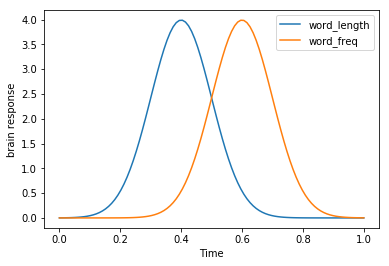

In [2]:
# Many neuroimaging study consist in identifying which factor cause brain activity.
# For example, some primary visual regions may respond proportionally to the size
# of a word (i.e. a low-level feature), whereas secondary areas may respond
# proportionnally to their frequency (i.e. a semantic, and thus high-level feature)
n_times = 100
time = np.linspace(0, 1, n_times)
word_length = norm.pdf(time, .4, .1)
word_freq = norm.pdf(time, .6, .1)
plt.plot(time, word_length, label='word_length')
plt.plot(time, word_freq, label='word_freq')
plt.xlabel('Time')
plt.ylabel('brain response')
plt.legend()

In [3]:
# Simulate 1000 brain responses to distinct words
Z = np.c_[word_length, word_freq].T  # typical dynamics of effects
n = 1000  # number of words
Cx = np.array([[1, .8], [.8, 1.]])  # feature covariance
X = np.random.multivariate_normal(np.zeros(2), Cx, n)  # word features
Y = X @ Z  # brain response
Y += np.random.randn(*Y.shape)  # add noise

Text(0,0.5,'betas')

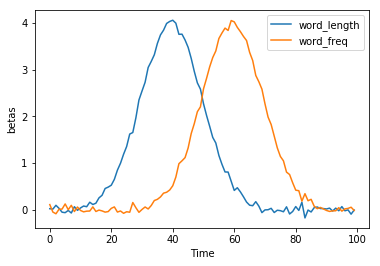

In [4]:
# Encoding analyses consist in predicting brain activity Y from the features X
# This approach can efficiently disentangle the causal contribution of each feature
ols = LinearRegression()
encod = list()
for t in range(n_times):
    encod.append(ols.fit(X, Y[:, t]).coef_)
plt.plot(encod)
plt.legend(['word_length', 'word_freq'])
plt.xlabel('Time')
plt.ylabel('betas')

Text(0,0.5,'decoding score')

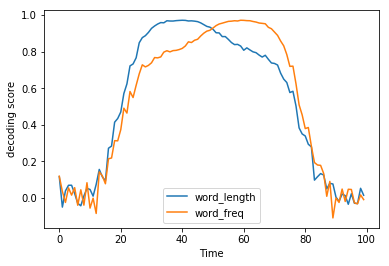

In [5]:
# Conversely, decoding analyses consist in predicting the features X from
# brain activity Y.
# This approach cannot efficiently disentangle the causal contribution of each feature

train, test = range(n//2), range(n//2, n)
ols = LinearRegression(fit_intercept=False)
decod = list()
for t in range(n_times):
    ols.fit(Y[train, t][:, None], X[train])
    X_hat = ols.predict(Y[test, t][:, None])
    R = list()
    for x, x_hat in zip(X[test].T, X_hat.T):
        r = pearsonr(x, x_hat)[0]
        R.append(r)
    decod.append(R)
plt.plot(decod)

plt.legend(['word_length', 'word_freq'])
plt.xlabel('Time')
plt.ylabel('decoding score')

In [6]:
# So why using decoding? Because we make multiple simultaneous measurements
# of noisy sources
F = np.array([[1., .5], [-.5, 1.]])  # forward: from source to sensor
Y = np.zeros((n, 2, n_times))
for t, (length, freq) in enumerate(zip(word_length, word_freq)):
    Z = np.c_[length, freq].T
    source = X @ Z
    # add source noise
    noise = np.random.randn(n) * 1e2
    source = np.c_[source, noise]
    # Y is now our multivariate measurement (i.e. sensors)
    Y[:, :, t] = source @ F
Y += np.random.randn(*Y.shape)  # add sensor noise

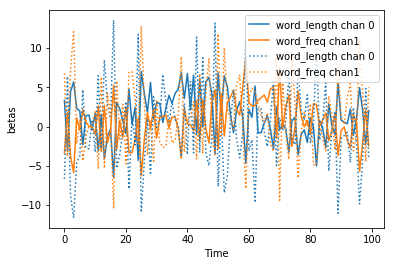

In [7]:
# In such condition, encoding can be dramatically bad
ols = LinearRegression()
nx = 2
ny = 2
multi_encod = np.zeros((nx, ny, n_times))
for c in range(ny):
    for t in range(n_times):
        multi_encod[:, c, t] = ols.fit(X, Y[:, c, t]).coef_
plt.legend(['word_length', 'word_freq'])

for c in range(2):
    for beta, label in enumerate(['word_length chan %i', 'word_freq chan%i']):
        plt.plot(multi_encod[beta, c].T, 
                 linestyle='-:'[c],
                 color='C%i' % beta, label=label % beta)
plt.xlabel('Time')
plt.ylabel('betas')
plt.legend()

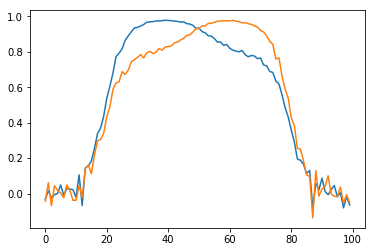

In [8]:
# whereas decoding clearly show that a lot of signal remain detectable
train, test = range(n//2), range(n//2, n)
ols = LinearRegression(fit_intercept=False)
multi_decod = list()
for t in range(n_times):
    ols.fit(Y[train, :, t], X[train])
    X_hat = ols.predict(Y[test, :, t])
    R = list()
    for x, x_hat in zip(X[test].T, X_hat.T):
        r = pearsonr(x, x_hat)[0]
        R.append(r)
    multi_decod.append(R)
plt.plot(multi_decod)

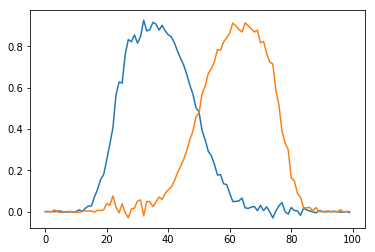

In [9]:
# Here is how we make the best of both world
jrr = JRR(G=LinearRegression(),
          H=LinearRegression())
multi_jrr = list()
for t in range(n_times):
    jrr.fit(X, Y[:, :, t])
    multi_jrr.append(np.diag(jrr.E_))
plt.plot(multi_jrr)

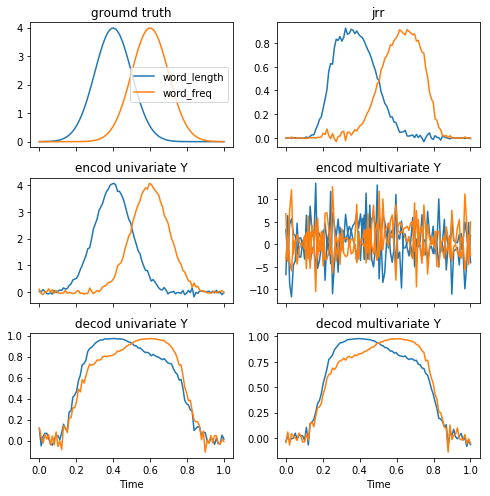

In [10]:
# all
fig, axes = plt.subplots(3, 2, figsize=[7, 7], sharex=True)
axes[0, 0].plot(time, word_length, label='word_length')
axes[0, 0].plot(time, word_freq, label='word_freq')
axes[0, 0].set_title('groumd truth')
axes[0, 0].legend()

axes[1, 0].plot(time, encod)
axes[1, 0].set_title('encod univariate Y')

axes[2, 0].plot(time, decod)
axes[2, 0].set_title('decod univariate Y')

axes[0, 1].plot(time, multi_jrr)
axes[0, 1].set_title('jrr')

axes[1, 1].plot(time, multi_encod[0].T, color='C0')
axes[1, 1].plot(time, multi_encod[1].T, color='C1')
axes[1, 1].set_title('encod multivariate Y')

axes[2, 1].plot(time, multi_decod)
axes[2, 1].set_title('decod multivariate Y')

axes[2, 0].set_xlabel('Time')
axes[2, 1].set_xlabel('Time')
fig.tight_layout()